**Importing Necessary Libraries**

In [2]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import calendar
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from geopy.geocoders import Nominatim
import time
from pprint import pprint
import warnings
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
import os
import math
from pathlib import Path

from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.metrics import (
    mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve, average_precision_score
)
from sklearn import ensemble, linear_model, neighbors, tree
from sklearn.preprocessing import PolynomialFeatures
from sklearn import model_selection, tree, linear_model, neighbors, naive_bayes, ensemble

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
submission_data = pd.read_csv('sample_submission.csv')

In [4]:
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
test_data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [7]:
submission_data.head()

,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959
3,id2150126,959
4,id1598245,959


In [8]:
print(train_data.dtypes)
print(test_data.dtypes)

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object
id                     object
vendor_id               int64
pickup_datetime        object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
dtype: object


In [10]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


**Removing rows that contain passenger_count == 0**

In [11]:
train_data.drop(train_data.index[train_data['passenger_count'] == 0], inplace = True)

In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1458584 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458584 non-null  object 
 1   vendor_id           1458584 non-null  int64  
 2   pickup_datetime     1458584 non-null  object 
 3   dropoff_datetime    1458584 non-null  object 
 4   passenger_count     1458584 non-null  int64  
 5   pickup_longitude    1458584 non-null  float64
 6   pickup_latitude     1458584 non-null  float64
 7   dropoff_longitude   1458584 non-null  float64
 8   dropoff_latitude    1458584 non-null  float64
 9   store_and_fwd_flag  1458584 non-null  object 
 10  trip_duration       1458584 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 133.5+ MB


**Normalizes the 'trip_duration' data by taking the natural logarithm and removes outliers based on a 2-sigma threshold**

In [14]:
train_data["trip_duraion"] =  np.log(train_data["trip_duration"])
mean = np.mean(train_data["trip_duration"])
std = np.std(train_data["trip_duration"])
train_data = train_data[train_data['trip_duration'] <= mean + 2*std]
train_data = train_data[train_data['trip_duration'] >= mean - 2*std]

**note:the boarders of NYC in cordinates (lat.., long..) is: -74.03, -73.75 for longitude and 40.63, 40.85 for latitude**

In [15]:
train_data = train_data[train_data['pickup_longitude'] <= -73.75]
train_data = train_data[train_data['pickup_longitude'] >= -74.03]
train_data = train_data[train_data['pickup_latitude'] <= 40.85]
train_data = train_data[train_data['pickup_latitude'] >= 40.63]
train_data = train_data[train_data['dropoff_longitude'] <= -73.75]
train_data = train_data[train_data['dropoff_longitude'] >= -74.03]
train_data = train_data[train_data['dropoff_latitude'] <= 40.85]
train_data = train_data[train_data['dropoff_latitude'] >= 40.63]

In [16]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,trip_duraion
count,1376528.000,1376528.000,1376528.000,1376528.000,1376528.000,1376528.000,1376528.000,1376528.000
mean,1.534,1.661,-73.977,40.752,-73.975,40.753,732.196,6.381
std,0.499,1.313,0.030,0.025,0.029,0.028,451.993,0.717
min,1.000,1.000,-74.030,40.630,-74.030,40.630,1.000,0.000
25%,1.000,1.000,-73.992,40.738,-73.991,40.737,384.000,5.951
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,630.000,6.446
75%,2.000,2.000,-73.968,40.768,-73.964,40.770,988.000,6.896
max,2.000,6.000,-73.751,40.850,-73.750,40.850,2154.000,7.675


In [18]:
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duraion
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,6.120
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,6.497
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,7.661
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,6.061
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,6.075


**EDA**

In [20]:
from sklearn.model_selection import train_test_split
y = train_data['trip_duration']
X = train_data.drop('trip_duration', axis=1)
#Set the number of examples in the validation and test groups
original_size = len(X)
heldout_size = int(original_size * 0.2)
#Allocate 20% of the data for testing, setting a random state for consistent results.
X, X_test, y, y_test = train_test_split(X, y, test_size=heldout_size, random_state=123)
# now split the remaining data into a training and a validation set. 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=heldout_size, random_state=123)

In [21]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape

((825918, 11), (275305, 11), (275305, 11), (825918,))

In [22]:
X_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duraion
count,825918.000,825918.000,825918.000,825918.000,825918.000,825918.000,825918.000
mean,1.533,1.662,-73.977,40.752,-73.975,40.753,6.381
std,0.499,1.313,0.030,0.025,0.029,0.028,0.716
min,1.000,1.000,-74.030,40.630,-74.030,40.630,0.000
25%,1.000,1.000,-73.992,40.738,-73.991,40.737,5.951
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,6.444
75%,2.000,2.000,-73.969,40.768,-73.964,40.770,6.895
max,2.000,6.000,-73.751,40.850,-73.750,40.850,7.675


**Histgram of the trip_duration**

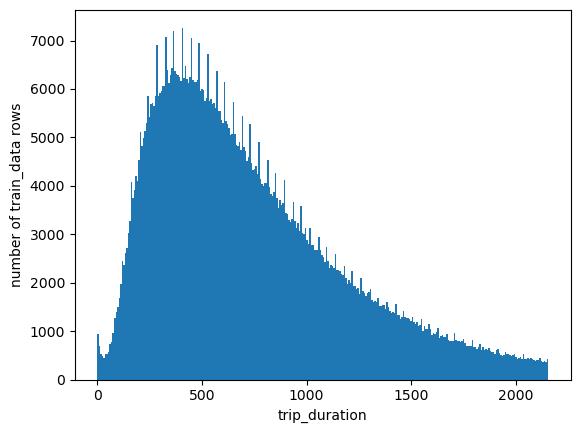

In [23]:
y_train.plot(kind='hist', bins=300);
plt.xlabel("trip_duration")
plt.ylabel('number of train_data rows')
plt.show()

**Histgram scaled trip_duration**

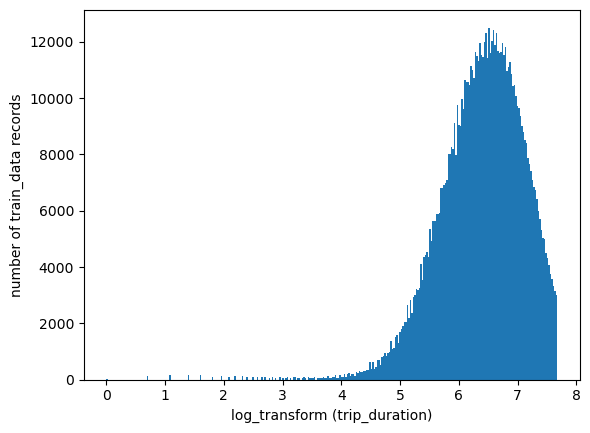

C:\Users\Delll\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='trip_duration', ylabel='Count'>

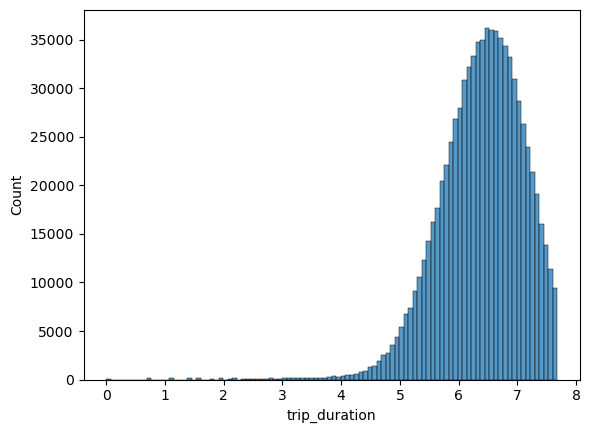

In [31]:
plt.hist(np.log(y_train), bins=300)
plt.xlabel('log_transform (trip_duration)')
plt.ylabel('number of train_data records')
plt.show()
sns.histplot(np.log(y_train), bins =100)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Time in Seconds')

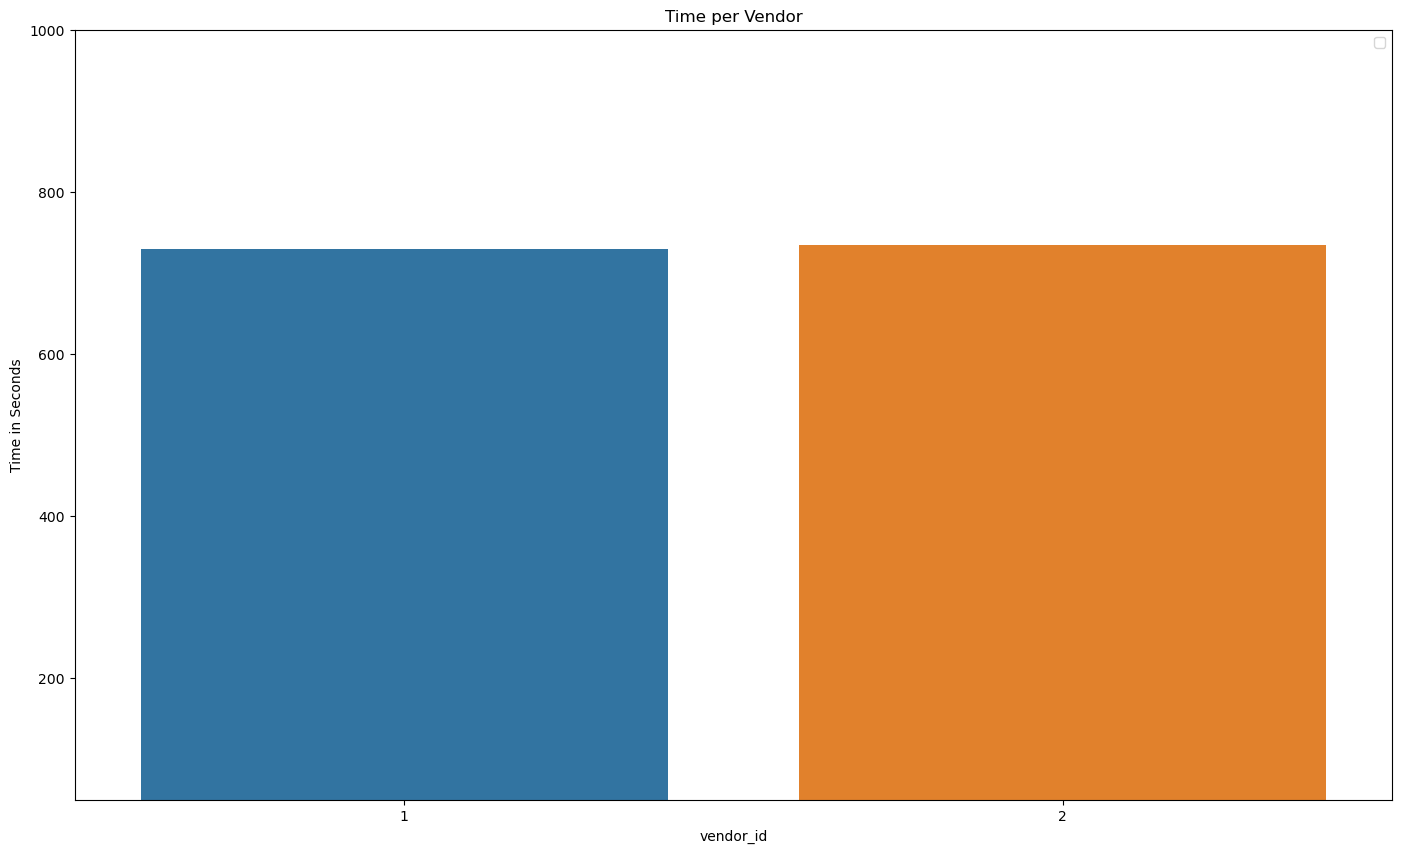

In [37]:
import pandas as pd
plot_vendor = train_data.groupby('vendor_id')['trip_duration'].mean()
plt.subplots(1,1,figsize=(17,10));
plt.ylim(ymin=50)
plt.ylim(ymax=1000)
plot_vendor_df = pd.DataFrame({'vendor_id': plot_vendor.index, 'trip_duration': plot_vendor.values})
sns.barplot(x='vendor_id', y='trip_duration', data=plot_vendor_df)
plt.title('Time per Vendor')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: title={'center': 'Time per store_and_fwd_flag'}, xlabel='store_and_fwd_flag', ylabel='trip_duration'>

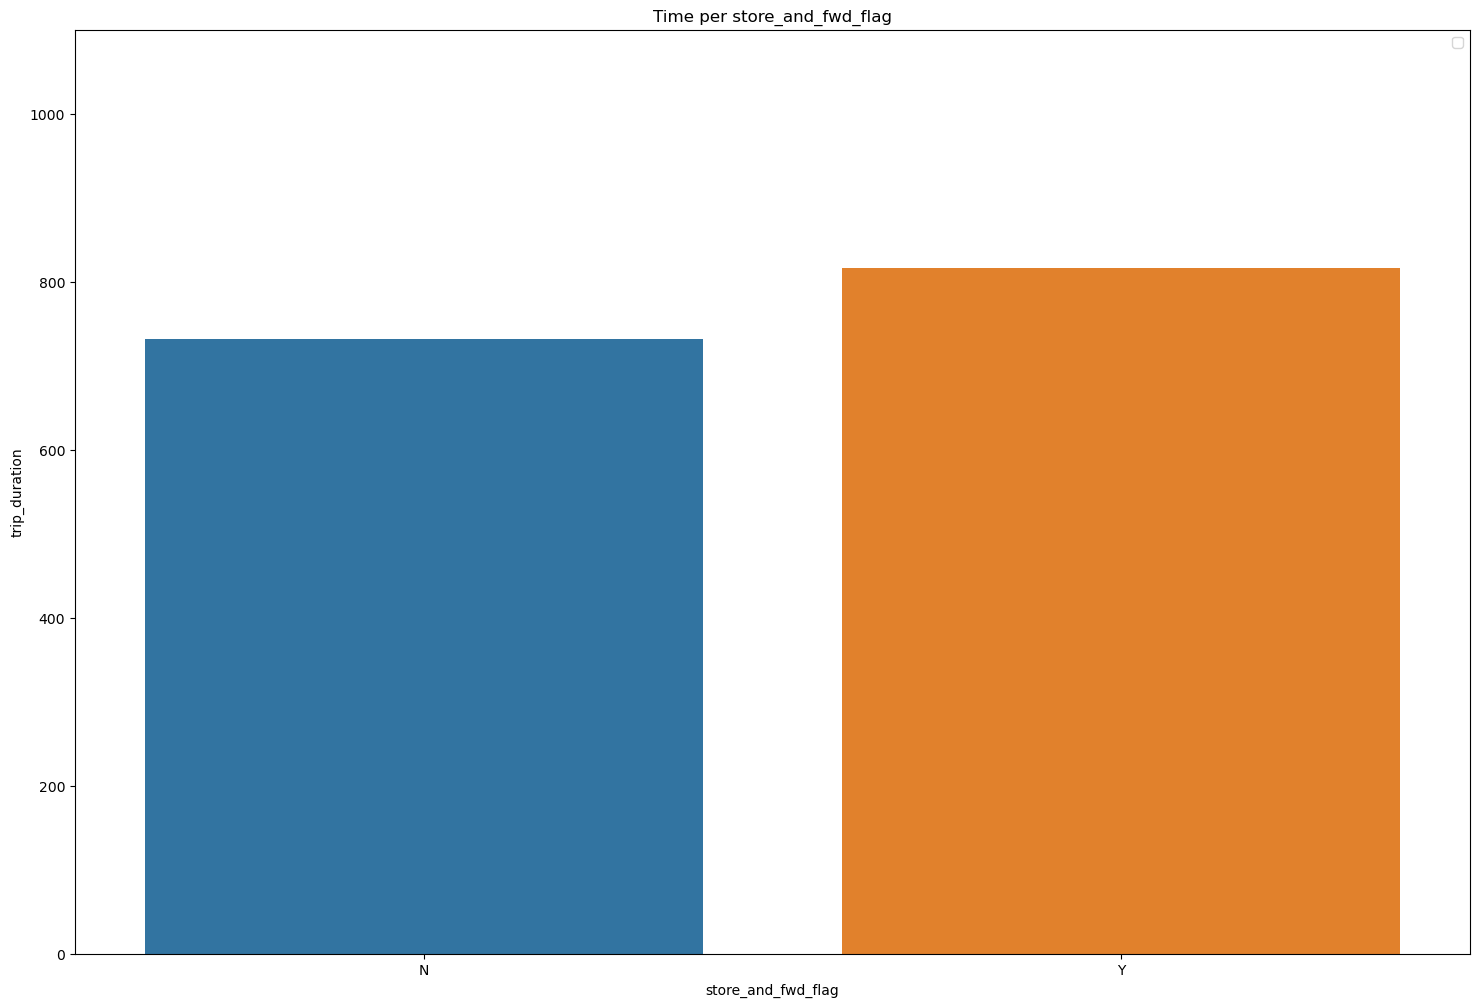

In [39]:
import pandas as pd
flag = train_data.groupby('store_and_fwd_flag')['trip_duration'].mean()
plt.subplots(1,1,figsize=(18,12))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
flag_df = pd.DataFrame({'store_and_fwd_flag': flag.index, 'trip_duration': flag.values})
sns.barplot(x='store_and_fwd_flag', y='trip_duration', data=flag_df)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: title={'center': 'numer of passengers'}, xlabel='passenger_count', ylabel='trip_duration'>

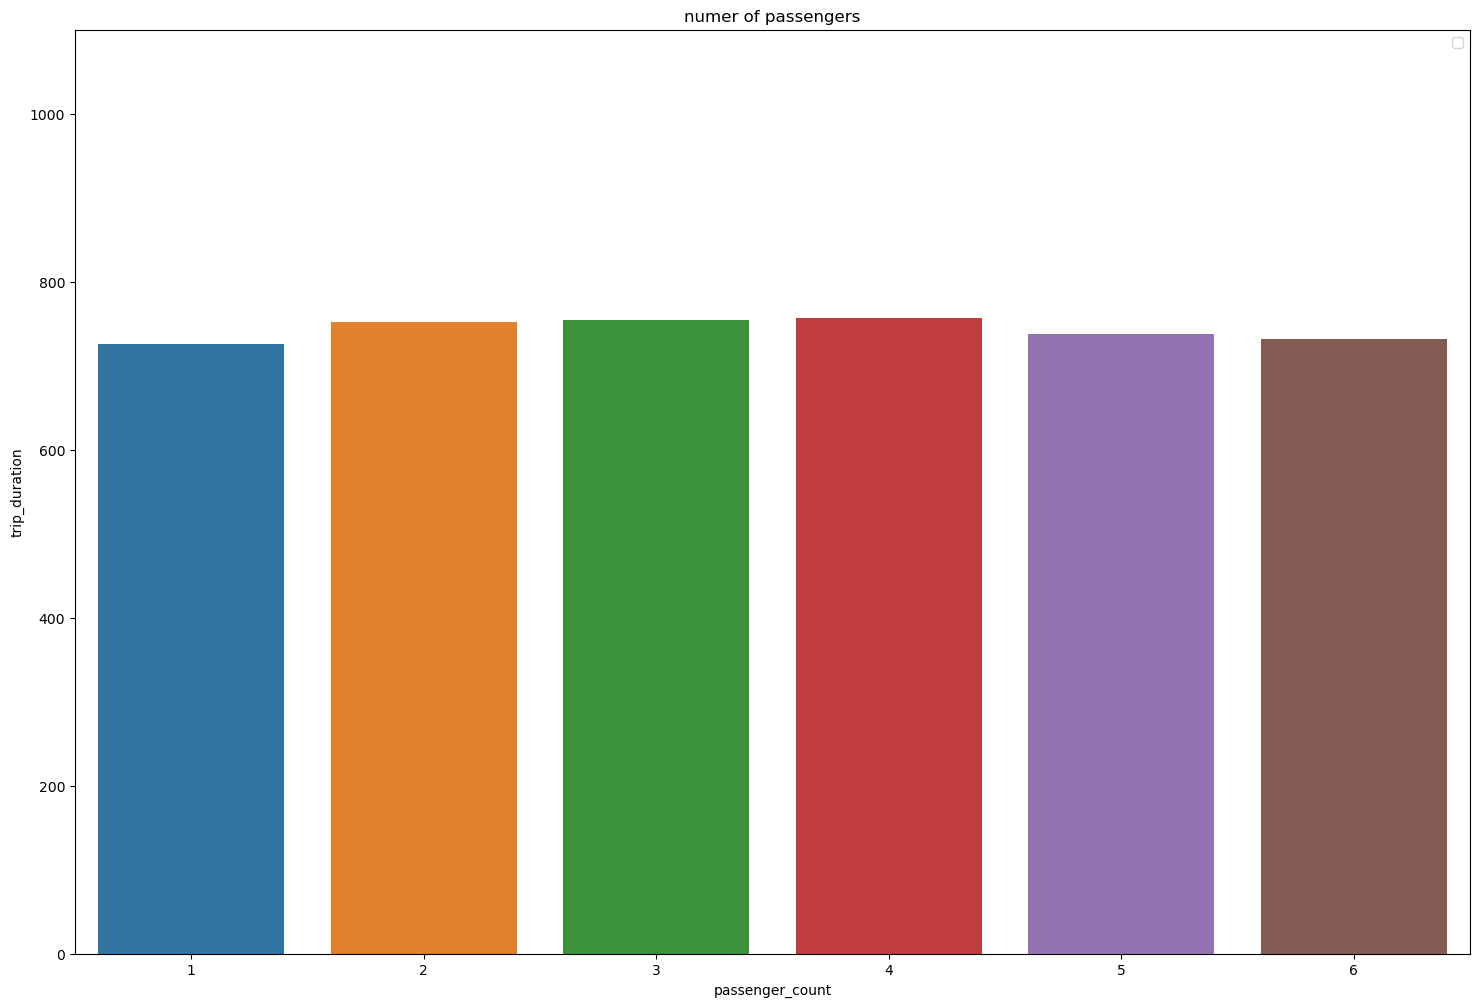

In [41]:
passenger_count = train_data.groupby('passenger_count')['trip_duration'].mean()
plt.subplots(1,1,figsize=(18,12))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('numer of passengers')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
import pandas as pd
passenger_count_df = pd.DataFrame({'passenger_count': passenger_count.index, 'trip_duration': passenger_count.values})
sns.barplot(x='passenger_count', y='trip_duration', data=passenger_count_df)

**Feature Engineering**

In [42]:
X_train['pickup_datetime'] = pd.to_datetime(X_train.pickup_datetime)
X_valid['pickup_datetime'] = pd.to_datetime(X_valid.pickup_datetime)
X_test ['pickup_datetime']  =  pd.to_datetime(X_test.pickup_datetime)

X_train.loc[:, 'pickup_date'] = X_train['pickup_datetime'].dt.date
X_valid.loc[:, 'pickup_date'] = X_valid['pickup_datetime'].dt.date
X_test.loc [:, 'pickup_date'] = X_test ['pickup_datetime'].dt.date

X_train['dropoff_datetime'] = pd.to_datetime(X_train.dropoff_datetime)
X_valid['dropoff_datetime'] = pd.to_datetime(X_valid.dropoff_datetime)
X_test ['dropoff_datetime'] = pd.to_datetime(X_test.dropoff_datetime)

**Functions to get Haversine Distance, Bearing Distance and manhattan_distance**

In [43]:
# 1 Haversine Distance
def haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

# 2 Bearing Distance 
def bearing_direction(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

# 3 Manhattan Distance
def manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_distance(lat1, lng1, lat1, lng2)
    b = haversine_distance(lat1, lng1, lat2, lng1)
    return a + b

In [44]:
X_train.loc[:, 'distance_haversine'] = haversine_distance(X_train['pickup_latitude'].values, X_train['pickup_longitude'].values, X_train['dropoff_latitude'].values, X_train['dropoff_longitude'].values)
X_valid.loc[:, 'distance_haversine'] = haversine_distance(X_valid['pickup_latitude'].values, X_valid['pickup_longitude'].values, X_valid['dropoff_latitude'].values, X_valid['dropoff_longitude'].values)
X_test.loc[:, 'distance_haversine'] = haversine_distance(X_test['pickup_latitude'].values, X_test['pickup_longitude'].values, X_test['dropoff_latitude'].values, X_test['dropoff_longitude'].values)

In [45]:
X_train.loc[:, "direction"] = bearing_direction(X_train["pickup_latitude"].values, X_train["pickup_longitude"].values, X_train["dropoff_latitude"].values, X_train["dropoff_longitude"].values)
X_valid.loc[:, "direction"] = bearing_direction(X_valid["pickup_latitude"].values, X_valid["pickup_longitude"].values, X_valid["dropoff_latitude"].values, X_valid["dropoff_longitude"].values)
X_test.loc[:, "direction"] = bearing_direction(X_test["pickup_latitude"].values, X_test["pickup_longitude"].values, X_test["dropoff_latitude"].values, X_test["dropoff_longitude"].values)

In [46]:
X_train.loc[:, "manhattan_distance"] =  manhattan_distance(X_train["pickup_latitude"].values, X_train["pickup_longitude"].values, X_train["dropoff_latitude"].values, X_train["dropoff_longitude"].values)
X_valid.loc[:, "manhattan_distance"] =  manhattan_distance(X_valid["pickup_latitude"].values, X_valid["pickup_longitude"].values, X_valid["dropoff_latitude"].values, X_valid["dropoff_longitude"].values)
X_test.loc[:, "manhattan_distance"] =   manhattan_distance(X_test["pickup_latitude"].values, X_test["pickup_longitude"].values, X_test["dropoff_latitude"].values, X_test["dropoff_longitude"].values)

In [47]:
X_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duraion,pickup_date,distance_haversine,direction,manhattan_distance
979487,id1162611,1,2016-01-30 23:11:43,2016-01-30 23:38:23,1,-73.964,40.807,-74.009,40.724,N,7.378,2016-01-30,10.064,-157.798,13.117
676645,id0091369,1,2016-06-16 12:30:15,2016-06-16 13:02:31,1,-73.969,40.754,-73.958,40.772,N,7.568,2016-06-16,2.182,25.462,2.908
1362152,id3775505,1,2016-04-23 01:02:29,2016-04-23 01:15:01,1,-73.997,40.721,-73.955,40.716,N,6.623,2016-04-23,3.605,99.085,4.130
810170,id2599366,1,2016-02-27 18:34:27,2016-02-27 18:49:18,1,-73.997,40.762,-73.987,40.741,N,6.792,2016-02-27,2.580,160.179,3.302
454867,id0984277,2,2016-04-10 09:11:44,2016-04-10 09:16:29,1,-73.955,40.765,-73.964,40.768,N,5.652,2016-04-10,0.811,-69.609,1.043


In [48]:
X_valid.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duraion,pickup_date,distance_haversine,direction,manhattan_distance
1301776,id2157061,1,2016-02-07 18:34:45,2016-02-07 18:54:07,1,-73.987,40.729,-74.000,40.761,N,7.058,2016-02-07,3.712,-16.037,4.594
1168894,id0013309,2,2016-04-16 01:50:19,2016-04-16 01:58:48,6,-74.006,40.745,-73.979,40.745,N,6.232,2016-04-16,2.348,88.956,2.390
484197,id2978271,1,2016-06-23 15:18:06,2016-06-23 15:43:37,1,-73.978,40.760,-73.991,40.751,N,7.334,2016-06-23,1.460,-133.084,2.063
253204,id3431073,1,2016-03-29 23:20:48,2016-03-29 23:28:35,1,-73.988,40.739,-73.981,40.750,N,6.146,2016-03-29,1.315,27.479,1.773
374492,id3369074,1,2016-01-30 17:30:52,2016-01-30 17:43:51,4,-73.987,40.740,-73.981,40.725,N,6.658,2016-01-30,1.701,164.790,2.087


In [50]:
X_train['Month'] = X_train['pickup_datetime'].dt.month
X_valid['Month'] = X_valid['pickup_datetime'].dt.month
X_test['Month'] = X_test['pickup_datetime'].dt.month

X_train["Day"] = X_train.pickup_datetime.dt.day
X_valid["Day"] = X_valid.pickup_datetime.dt.day
X_test["Day"] = X_test.pickup_datetime.dt.day

X_train["Hour"] = X_train.pickup_datetime.dt.hour
X_valid["Hour"] = X_valid.pickup_datetime.dt.hour
X_test["Hour"] = X_test.pickup_datetime.dt.hour

X_train["Day_week"] = X_train["pickup_datetime"].dt.dayofweek
X_valid["Day_week"] = X_valid["pickup_datetime"].dt.dayofweek
X_test["Day_week"] = X_test["pickup_datetime"].dt.dayofweek

X_train["Week"] = X_train.pickup_datetime.dt.isocalendar().week
X_valid["Week"] = X_valid.pickup_datetime.dt.isocalendar().week
X_test["Week"] = X_test.pickup_datetime.dt.isocalendar().week

In [51]:
X_train = pd.get_dummies(X_train, columns=['store_and_fwd_flag'])
X_valid = pd.get_dummies(X_valid, columns=['store_and_fwd_flag'])
X_test = pd.get_dummies(X_test, columns=['store_and_fwd_flag'])

In [52]:
X_train['store_and_fwd_flag_N'] = X_train['store_and_fwd_flag_N'].astype(np.int64)
X_valid['store_and_fwd_flag_N'] = X_valid['store_and_fwd_flag_N'].astype(np.int64)
X_test['store_and_fwd_flag_N'] = X_test['store_and_fwd_flag_N'].astype(np.int64)

X_train['store_and_fwd_flag_Y'] = X_train['store_and_fwd_flag_Y'].astype(np.int64)
X_valid['store_and_fwd_flag_Y'] = X_valid['store_and_fwd_flag_Y'].astype(np.int64)
X_test['store_and_fwd_flag_Y'] = X_test['store_and_fwd_flag_Y'].astype(np.int64)

**Drop some Features that isn't important to our model**

In [53]:
X_train.drop("id", axis=1, inplace=True)
X_train.drop("vendor_id", axis=1, inplace=True)
X_train.drop("Week", axis=1, inplace=True)

X_valid.drop("id", axis=1, inplace=True)
X_valid.drop("vendor_id", axis=1, inplace=True)
X_valid.drop("Week", axis=1, inplace=True)

X_test.drop("id", axis=1, inplace=True)
X_test.drop("vendor_id", axis=1, inplace=True)
X_test.drop("Week", axis=1, inplace=True)

In [54]:
X_train.drop("pickup_date", axis=1, inplace=True)
X_valid.drop("pickup_date", axis=1, inplace=True)
X_test.drop("pickup_date", axis=1, inplace=True)
X_train.dtypes

pickup_datetime         datetime64[ns]
dropoff_datetime        datetime64[ns]
passenger_count                  int64
pickup_longitude               float64
pickup_latitude                float64
dropoff_longitude              float64
dropoff_latitude               float64
trip_duraion                   float64
distance_haversine             float64
direction                      float64
manhattan_distance             float64
Month                            int32
Day                              int32
Hour                             int32
Day_week                         int32
store_and_fwd_flag_N             int64
store_and_fwd_flag_Y             int64
dtype: object

**Check if the trip day is a national holiday or near_holiday day**

In [55]:
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays()

X_train['pickup_holiday'] = pd.to_datetime(X_train.pickup_datetime.dt.date).isin(holidays)
X_train['pickup_holiday'] = X_train.pickup_holiday.map(lambda x: 1 if x == True else 0)
X_train['pickup_near_holiday'] = (pd.to_datetime(X_train.pickup_datetime.dt.date).isin(holidays + timedelta(days=1)) | pd.to_datetime(X_train.pickup_datetime.dt.date).isin(holidays - timedelta(days=1)))
X_train['pickup_near_holiday'] = X_train.pickup_near_holiday.map(lambda x: 1 if x == True else 0)

In [56]:
X_test['pickup_holiday'] = pd.to_datetime(X_test.pickup_datetime.dt.date).isin(holidays)
X_test['pickup_holiday'] = X_test.pickup_holiday.map(lambda x: 1 if x == True else 0)
X_test['pickup_near_holiday'] = (pd.to_datetime(X_test.pickup_datetime.dt.date).isin(holidays + timedelta(days=1)) | pd.to_datetime(X_test.pickup_datetime.dt.date).isin(holidays - timedelta(days=1)))
X_test['pickup_near_holiday'] = X_test.pickup_near_holiday.map(lambda x: 1 if x == True else 0)

In [57]:
X_valid['pickup_holiday'] = pd.to_datetime(X_valid.pickup_datetime.dt.date).isin(holidays)
X_valid['pickup_holiday'] = X_valid.pickup_holiday.map(lambda x: 1 if x == True else 0)
X_valid['pickup_near_holiday'] = (pd.to_datetime(X_valid.pickup_datetime.dt.date).isin(holidays + timedelta(days=1)) | pd.to_datetime(X_valid.pickup_datetime.dt.date).isin(holidays - timedelta(days=1)))
X_valid['pickup_near_holiday'] = X_valid.pickup_near_holiday.map(lambda x: 1 if x == True else 0)

In [58]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 825918 entries, 979487 to 1110644
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   pickup_datetime       825918 non-null  datetime64[ns]
 1   dropoff_datetime      825918 non-null  datetime64[ns]
 2   passenger_count       825918 non-null  int64         
 3   pickup_longitude      825918 non-null  float64       
 4   pickup_latitude       825918 non-null  float64       
 5   dropoff_longitude     825918 non-null  float64       
 6   dropoff_latitude      825918 non-null  float64       
 7   trip_duraion          825918 non-null  float64       
 8   distance_haversine    825918 non-null  float64       
 9   direction             825918 non-null  float64       
 10  manhattan_distance    825918 non-null  float64       
 11  Month                 825918 non-null  int32         
 12  Day                   825918 non-null  int32         
 13

In [59]:
X_train

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duraion,distance_haversine,direction,manhattan_distance,Month,Day,Hour,Day_week,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_holiday,pickup_near_holiday
979487,2016-01-30 23:11:43,2016-01-30 23:38:23,1,-73.964,40.807,-74.009,40.724,7.378,10.064,-157.798,13.117,1,30,23,5,1,0,0,0
676645,2016-06-16 12:30:15,2016-06-16 13:02:31,1,-73.969,40.754,-73.958,40.772,7.568,2.182,25.462,2.908,6,16,12,3,1,0,0,0
1362152,2016-04-23 01:02:29,2016-04-23 01:15:01,1,-73.997,40.721,-73.955,40.716,6.623,3.605,99.085,4.130,4,23,1,5,1,0,0,0
810170,2016-02-27 18:34:27,2016-02-27 18:49:18,1,-73.997,40.762,-73.987,40.741,6.792,2.580,160.179,3.302,2,27,18,5,1,0,0,0
454867,2016-04-10 09:11:44,2016-04-10 09:16:29,1,-73.955,40.765,-73.964,40.768,5.652,0.811,-69.609,1.043,4,10,9,6,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452516,2016-06-04 08:23:08,2016-06-04 08:35:06,1,-73.946,40.775,-73.985,40.772,6.576,3.331,-95.306,3.626,6,4,8,5,1,0,0,0
1073134,2016-06-08 07:22:44,2016-06-08 07:34:22,1,-73.982,40.731,-73.955,40.766,6.548,4.453,31.191,6.116,6,8,7,2,1,0,0,0
984594,2016-05-23 22:21:05,2016-05-23 22:26:48,1,-73.993,40.748,-74.005,40.748,5.838,1.018,-89.113,1.034,5,23,22,0,1,0,0,0
454061,2016-02-20 00:09:51,2016-02-20 00:18:45,1,-73.984,40.729,-73.964,40.756,6.280,3.447,28.801,4.681,2,20,0,5,1,0,0,0


In [60]:
X_train.drop("pickup_datetime", axis=1, inplace=True)
X_train.drop("dropoff_datetime", axis=1, inplace=True)
X_train.drop("pickup_longitude", axis=1, inplace=True)
X_train.drop("pickup_latitude", axis=1, inplace=True)
X_train.drop("dropoff_longitude", axis=1, inplace=True)
X_train.drop("dropoff_latitude", axis=1, inplace=True)



X_valid.drop("pickup_datetime", axis=1, inplace=True)
X_valid.drop("dropoff_datetime", axis=1, inplace=True)
X_valid.drop("pickup_longitude", axis=1, inplace=True)
X_valid.drop("pickup_latitude", axis=1, inplace=True)
X_valid.drop("dropoff_longitude", axis=1, inplace=True)
X_valid.drop("dropoff_latitude", axis=1, inplace=True)


X_test.drop("pickup_datetime", axis=1, inplace=True)
X_test.drop("dropoff_datetime", axis=1, inplace=True)
X_test.drop("pickup_longitude", axis=1, inplace=True)
X_test.drop("pickup_latitude", axis=1, inplace=True)
X_test.drop("dropoff_longitude", axis=1, inplace=True)
X_test.drop("dropoff_latitude", axis=1, inplace=True)

In [61]:
X_train = pd.get_dummies(X_train, columns=['Hour'])
X_valid = pd.get_dummies(X_valid, columns=['Hour'])
X_test = pd.get_dummies(X_test, columns=['Hour'])

In [62]:
X_train = pd.get_dummies(X_train, columns=['Month'])
X_valid = pd.get_dummies(X_valid, columns=['Month'])
X_test = pd.get_dummies(X_test, columns=['Month'])

In [63]:
X_train = pd.get_dummies(X_train, columns=['Day'])
X_valid = pd.get_dummies(X_valid, columns=['Day'])
X_test = pd.get_dummies(X_test, columns=['Day'])

In [64]:
X_train = pd.get_dummies(X_train, columns=['Day_week'])
X_valid = pd.get_dummies(X_valid, columns=['Day_week'])
X_test = pd.get_dummies(X_test, columns=['Day_week'])

**Scalling**

In [65]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train[["manhattan_distance"]] = scaler.fit_transform(X_train[["manhattan_distance"]])
X_train[["distance_haversine"]] = scaler.fit_transform(X_train[["distance_haversine"]])
X_train[["direction"]] = scaler.fit_transform(X_train[["direction"]])

In [66]:
X_valid[["manhattan_distance"]] = scaler.fit_transform(X_valid[["manhattan_distance"]])
X_valid[["distance_haversine"]] = scaler.fit_transform(X_valid[["distance_haversine"]])
X_valid[["direction"]] = scaler.fit_transform(X_valid[["direction"]])

In [67]:
X_test[["manhattan_distance"]] = scaler.fit_transform(X_test[["manhattan_distance"]])
X_test[["distance_haversine"]] = scaler.fit_transform(X_test[["distance_haversine"]])
X_test[["direction"]] = scaler.fit_transform(X_test[["direction"]])

In [68]:
X_train.head()

,passenger_count,trip_duraion,distance_haversine,direction,manhattan_distance,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_holiday,pickup_near_holiday,Hour_0,...,Day_29,Day_30,Day_31,Day_week_0,Day_week_1,Day_week_2,Day_week_3,Day_week_4,Day_week_5,Day_week_6
979487,1,7.378,0.383,0.062,0.365,1,0,0,0,False,...,False,True,False,False,False,False,False,False,True,False
676645,1,7.568,0.083,0.571,0.081,1,0,0,0,False,...,False,False,False,False,False,False,True,False,False,False
1362152,1,6.623,0.137,0.775,0.115,1,0,0,0,False,...,False,False,False,False,False,False,False,False,True,False
810170,1,6.792,0.098,0.945,0.092,1,0,0,0,False,...,False,False,False,False,False,False,False,False,True,False
454867,1,5.652,0.031,0.307,0.029,1,0,0,0,False,...,False,False,False,False,False,False,False,False,False,True


In [69]:
X_train.describe()

,passenger_count,trip_duraion,distance_haversine,direction,manhattan_distance,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_holiday,pickup_near_holiday
count,825918.000,825918.000,825918.000,825918.000,825918.000,825918.000,825918.000,825918.000,825918.000
mean,1.662,6.381,0.108,0.456,0.102,0.995,0.005,0.019,0.036
std,1.313,0.716,0.105,0.291,0.101,0.070,0.070,0.137,0.186
min,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,5.951,0.045,0.144,0.042,1.000,0.000,0.000,0.000
50%,1.000,6.444,0.075,0.525,0.071,1.000,0.000,0.000,0.000
75%,2.000,6.895,0.131,0.647,0.124,1.000,0.000,0.000,0.000
max,6.000,7.675,1.000,1.000,1.000,1.000,1.000,1.000,1.000


**Modeling**

**Using Ridge Regrission**

In [70]:
from sklearn.linear_model import Ridge
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

Ridge()

In [74]:
from sklearn.metrics import r2_score

y_pred_valid = model.predict(X_valid)
y_pred_train = model.predict(X_train)

r2_valid = r2_score(y_valid, y_pred_valid)
r2_train = r2_score(y_train, y_pred_train)
print(f"Validation R^2: {r2_valid:.4f}")
print(f"Training R^2: {r2_train:.4f}")

Validation R^2: 0.8555
Training R^2: 0.8559
